In [6]:
import cudaq
import numpy as np
from scipy.optimize import minimize
from typing import List, Tuple

In [7]:
#Creating Hamiltonian 
def build_labs_hamiltonian(n_qubits: int) -> cudaq.SpinOperator:
    hamiltonian = cudaq.SpinOperator()
    
    for k in range(1, n_qubits):
        for i in range(n_qubits - k):
            for j in range(n_qubits - k):
                # Count Z occurrences at each site
                z_count = [0] * n_qubits
                for idx in [i, i + k, j, j + k]:
                    z_count[idx] += 1
                
                # Build Pauli term (Z^2 = I)
                term = cudaq.SpinOperator()
                coeff = 1.0
                has_z = False
                
                for site in range(n_qubits):
                    if z_count[site] % 2 == 1:  # Odd count = Z
                        if not has_z:
                            term = cudaq.spin.z(site)
                            has_z = True
                        else:
                            term *= cudaq.spin.z(site)
                
                if has_z:
                    hamiltonian += term
                else:
                    # Identity term (even Z count everywhere)
                    hamiltonian += cudaq.SpinOperator()
    
    return hamiltonian

In [8]:
@cudaq.kernel
def hea_ansatz(qubits: cudaq.qview, params: List[float], n_layers: int):
  
    n_qubits = qubits.size()
    param_idx = 0
    
    for layer in range(n_layers):
        # Single-qubit rotations
        for qubit in range(n_qubits):
            ry(params[param_idx], qubits[qubit])
            param_idx += 1
            rz(params[param_idx], qubits[qubit])
            param_idx += 1
        
        # Entangling layer: CNOT ladder
        for qubit in range(n_qubits - 1):
            x.ctrl(qubits[qubit], qubits[qubit + 1])
        
        # Circular entanglement
        x.ctrl(qubits[n_qubits - 1], qubits[0])

In [102]:
# @cudaq.kernel
# def vqe_circuit(params: List[float]):
#     qubits = cudaq.qvector(n_qubits)
#     hea_ansatz(qubits, params, n_layers)


# @cudaq.kernel
# def vqe_circuit_measure(params: List[float]):
#     qubits = cudaq.qvector(n_qubits)
#     hea_ansatz(qubits, params, n_layers)
#     mz(qubits)

@cudaq.kernel
def vqe_circuit(n_qubits: int, n_layers: int, params: List[float]):
    qubits = cudaq.qvector(n_qubits)
    hea_ansatz(qubits, params, n_layers)


@cudaq.kernel
def vqe_circuit_measure(n_qubits: int, n_layers: int, params: List[float]):
    qubits = cudaq.qvector(n_qubits)
    hea_ansatz(qubits, params, n_layers)
    mz(qubits)



In [103]:
#VQE optimizaton
def run_vqe_optimization(
    hamiltonian: cudaq.SpinOperator,
    initial_params: np.ndarray,
    n_qubits: int, n_layers:int,
    maxiter: int = 200
) -> Tuple[np.ndarray, float, List[float]]:

    energy_history = []
    
    def objective(params):
        # GPU: cudaq.observe() runs efficiently on GPU
        # CPU: Falls back to CPU simulation
        result = result = cudaq.observe(vqe_circuit, hamiltonian,
                       n_qubits, n_layers, params.tolist())
        energy = result.expectation()
        energy_history.append(energy)
        return energy
    
    # ============================================================
    # OPTIMIZER OPTIONS (choose based on problem size)
    # ============================================================
    
    # Option 1: COBYLA - Gradient-free, robust for noisy landscapes
    # Good for: Small problems, noisy simulations
    result = minimize(
        objective,
        initial_params,
        method='COBYLA',
        options={
            'maxiter': maxiter,      # GPU: increase to 500-1000
            'rhobeg': 0.5,           # Initial step size
            'tol': 1e-6
        }
    )
    
     # Option 2: L-BFGS-B - Gradient-based, faster convergence
    # Good for: Larger problems on GPU, smooth landscapes
    # Uncomment to use:
    # result = minimize(
    #     objective,
    #     initial_params,
    #     method='L-BFGS-B',
    #     options={'maxiter': maxiter, 'ftol': 1e-8}
    # )
    
    return result.x, result.fun, energy_history

In [106]:

def sample_population(n_qubits, n_layers, optimized_params, n_samples=100, seed=42):
    np.random.seed(seed)
    counts = cudaq.sample(vqe_circuit_measure,
                      n_qubits,
                      n_layers,
                      optimized_params.tolist(),
                      shots_count=n_samples)
    return counts

def convert_sample_to_arr(sample, n_qubits, shots=100): 
    arr = np.zeros((shots, n_qubits), dtype=int)
    print(n_qubits, np.shape(arr))
    idx = 0
    for bitstring, count in sample.items():
        for _ in range(count):
            # Convert bitstring to array of 0/1
            row = np.array([int(b) for b in bitstring], dtype=int)
            # Change 0 -> -1
            row[row == 0] = -1
            arr[idx, :] = row
            idx += 1
    return arr

In [110]:
def generate_quantum_pop(n_qubits,n_layers, n_pop, max_iter = 200):
    n_params = 2 * n_qubits * n_layers

    print("\n[1] Building LABS Hamiltonian...")
    hamiltonian = build_labs_hamiltonian(n_qubits)

    print("\n[2] Initializing variational parameters...")
    np.random.seed(42)
    initial_params = np.random.uniform(-np.pi/4, np.pi/4, n_params)

    # Run VQE optimization
    print("\n[3] Running VQE optimization...")

    optimized_params, final_energy, history = run_vqe_optimization(
    hamiltonian, initial_params, n_qubits, n_layers, maxiter = 100
    )


    print(f"    Final energy: {final_energy:.6f}")

    print("\n[4] Sampling population for classical seeding...")
    counts = sample_population(n_qubits, n_layers, optimized_params, n_samples=n_pop)
    
    quantum_pop = convert_sample_to_arr(counts,n_qubits,n_pop)

    print("\n[5] Population generated, Size:", np.shape(quantum_pop))
    return history,quantum_pop

In [25]:
import numpy as np
from typing import List, Tuple, Optional, Set
from dataclasses import dataclass
from collections import deque
import time

# GPU: import cupy as cp  # For GPU-accelerated numpy operations
# GPU: from numba import cuda, jit  # For custom CUDA kernels

In [68]:
def compute_energy_fft(sequence: np.ndarray) -> float:
    n = len(sequence)
    padded = np.zeros(2 * n)
    padded[:n] = sequence
    # FFT-based autocorrelation 
    fft_result = np.fft.fft(padded)
    power_spectrum = np.abs(fft_result) ** 2
    autocorr = np.fft.ifft(power_spectrum).real
    # Return only the valid autocorrelation values
    autocorr = autocorr[:n]
    energy = np.sum(autocorr[1:] ** 2)
    return float(energy)

In [87]:
@dataclass
class TabuSearchConfig:
    """Configuration for Tabu Search."""
    tabu_tenure: int = 7          # How long a move stays tabu
    max_iterations: int = 1000    # Max iterations without improvement
    aspiration_threshold: float = 0.0  # Accept tabu move if improves best by this much

class TabuList:
    def __init__(self, tenure: int):
        self.tenure = tenure
        self.tabu_moves = deque(maxlen=tenure)
        self.tabu_set = set()  # O(1) lookup
    
    def add(self, move: int):
        if len(self.tabu_moves) == self.tenure:
            # Remove oldest move from set
            old_move = self.tabu_moves[0]
            self.tabu_set.discard(old_move)
        
        self.tabu_moves.append(move)
        self.tabu_set.add(move)
    
    def is_tabu(self, move: int) -> bool:
        """Check if a move is tabu."""
        return move in self.tabu_set
    
    def clear(self):
        """Clear the tabu list."""
        self.tabu_moves.clear()
        self.tabu_set.clear()


def compute_flip_delta_fft(sequence: np.ndarray, flip_idx: int) -> float:
    n = len(sequence)

    old_energy = compute_energy_fft(sequence)
    
    # Create flipped sequence
    new_sequence = sequence.copy()
    new_sequence[flip_idx] *= -1
    
    # New energy
    new_energy =  compute_energy_fft(sequence)
    return new_energy - old_energy

In [71]:

def tabu_search_local( sequence: np.ndarray, config: TabuSearchConfig, verbose: bool = False
) -> Tuple[np.ndarray, float, int]:

    n = len(sequence)
    current = sequence.copy()
    current_energy = compute_energy_fft(current)
    
    best = current.copy()
    best_energy = current_energy
    
    tabu_list = TabuList(config.tabu_tenure)
    
    iterations_without_improvement = 0
    total_iterations = 0
    
    while iterations_without_improvement < config.max_iterations:
        total_iterations += 1
        
        best_move = -1
        best_move_energy = float('inf')
        best_non_tabu_move = -1
        best_non_tabu_energy = float('inf')
        
        for i in range(n):
            # Compute energy after flipping bit i
            test_seq = current.copy()
            test_seq[i] *= -1
            test_energy = compute_energy_fft(test_seq)
            
            # Track best move overall (for aspiration)
            if test_energy < best_move_energy:
                best_move = i
                best_move_energy = test_energy
            
            # Track best non-tabu move
            if not tabu_list.is_tabu(i) and test_energy < best_non_tabu_energy:
                best_non_tabu_move = i
                best_non_tabu_energy = test_energy
        
        # Apply aspiration criterion: accept tabu move if it's much better
        if best_move_energy < best_energy - config.aspiration_threshold:
            chosen_move = best_move
            chosen_energy = best_move_energy
        elif best_non_tabu_move >= 0:
            chosen_move = best_non_tabu_move
            chosen_energy = best_non_tabu_energy
        else:
            # All moves are tabu and none satisfy aspiration
            break
        
        # Apply the move
        current[chosen_move] *= -1
        current_energy = chosen_energy
        tabu_list.add(chosen_move)
        
        # Update best
        if current_energy < best_energy:
            best = current.copy()
            best_energy = current_energy
            iterations_without_improvement = 0
        else:
            iterations_without_improvement += 1
    
    return best, best_energy, total_iterations


In [113]:
@dataclass
class MTSConfig:
    """Configuration for Memetic Tabu Search."""
    # Population parameters
    population_size: int = 50
    elite_size: int = 5           # Number of best solutions to preserve
    
    # Tabu search parameters
    tabu_tenure: int = 7
    local_search_iterations: int = 100
    
    # Genetic operators
    crossover_rate: float = 0.8
    mutation_rate: float = 0.1
    
    # Termination
    max_generations: int = 100
    stagnation_limit: int = 20    # Stop if no improvement for this many generations
    
    # Intensification/Diversification
    intensify_threshold: int = 5  # Intensify after this many stagnant generations
    diversify_threshold: int = 10 # Diversify after this many stagnant generations

class MemeticTabuSearch:
    
    def __init__(self, n_qubits: int, config: MTSConfig = None):
        self.n_qubits = n_qubits
        self.config = config or MTSConfig()
        
        # Tracking
        self.best_sequence = None
        self.best_energy = float('inf')
        self.best_merit_factor = 0.0
        self.history = []
        
        # Statistics
        self.total_evaluations = 0
        self.generation = 0
       
    def evaluate_population(self, population: np.ndarray) -> np.ndarray:
        fitness = np.array([compute_energy_fft(seq) for seq in population])
        self.total_evaluations += len(population)
        return fitness
    
    def select_parents(self, population: np.ndarray, fitness: np.ndarray) -> np.ndarray:
        tournament_size = 3
        n_parents = len(population)
        parents = []
        
        for _ in range(n_parents):
            # Random tournament
            indices = np.random.choice(len(population), size=tournament_size, replace=False)
            tournament_fitness = fitness[indices]
            winner_idx = indices[np.argmin(tournament_fitness)]
            parents.append(population[winner_idx].copy())
        return np.array(parents)
    
    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if np.random.random() > self.config.crossover_rate:
            return parent1.copy(), parent2.copy()
        
        n = len(parent1)
        # Two-point crossover
        points = sorted(np.random.choice(n, size=2, replace=False))
    
        child1 = parent1.copy()
        child2 = parent2.copy()
        child1[points[0]:points[1]] = parent2[points[0]:points[1]]
        child2[points[0]:points[1]] = parent1[points[0]:points[1]]
        
        return child1, child2
    
    def mutate(self, sequence: np.ndarray) -> np.ndarray:
        mutated = sequence.copy()
        for i in range(len(mutated)):
            if np.random.random() < self.config.mutation_rate:
                mutated[i] *= -1
        return mutated
    
    def local_search(self, sequence: np.ndarray) -> Tuple[np.ndarray, float]:
        config = TabuSearchConfig(
            tabu_tenure=self.config.tabu_tenure,
            max_iterations=self.config.local_search_iterations
        )
        
        improved, energy, _ = tabu_search_local(sequence, config)
        return improved, energy
    
    def intensification(self, population: np.ndarray, fitness: np.ndarray) -> np.ndarray:
        # Get elite solutions
        elite_indices = np.argsort(fitness)[:self.config.elite_size]
        elite = population[elite_indices]
        
        # Create perturbations of elite
        new_population = list(population)
        for elite_seq in elite:
            # Create variations with 1-2 bit flips
            for _ in range(2):
                variant = elite_seq.copy()
                n_flips = np.random.randint(1, 3)
                flip_positions = np.random.choice(len(variant), size=n_flips, replace=False)
                for pos in flip_positions:
                    variant[pos] *= -1
                new_population.append(variant)
        
        # Keep population size constant
        new_population = np.array(new_population)
        new_fitness = self.evaluate_population(new_population)
        best_indices = np.argsort(new_fitness)[:self.config.population_size]
        
        return new_population[best_indices]
    
    def diversification(self, population: np.ndarray, fitness: np.ndarray) -> np.ndarray:
        # Keep elite
        elite_indices = np.argsort(fitness)[:self.config.elite_size]
        elite = population[elite_indices]
        
        # Generate new random solutions
        n_new = self.config.population_size - self.config.elite_size
        new_solutions = np.random.choice([-1, 1], size=(n_new, self.n_qubits))
        
        # Combine elite with new solutions
        return np.vstack([elite, new_solutions])
    
    def run(self, 
            quantum_seeds:[np.ndarray],
            verbose: bool = True) -> Tuple[np.ndarray, float, float, np.ndarray]:
        
        if verbose:
            print(f"Sequence length: {self.n_qubits}")
            print(f"Population size: {self.config.population_size}")
            print(f"Max generations: {self.config.max_generations}")
            if quantum_seeds is not None:
                print(f"Quantum seeds: {len(quantum_seeds)}")
        
        # Initialize population
        population = quantum_seeds
        fitness = self.evaluate_population(population)
        
        # Track best
        best_idx = np.argmin(fitness)
        self.best_sequence = population[best_idx].copy()
        self.best_energy = fitness[best_idx]
        
        stagnation_counter = 0
        
        if verbose:
            print(f"\nInitial best: E={self.best_energy:.2f}")
            print("\n[Generation Progress]")
        
        for gen in range(self.config.max_generations):
            self.generation = gen
            
            # Selection
            parents = self.select_parents(population, fitness)
            
            # Crossover and Mutation
            offspring = []
            for i in range(0, len(parents) - 1, 2):
                child1, child2 = self.crossover(parents[i], parents[i + 1])
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                offspring.extend([child1, child2])
            
            # Handle odd population size
            if len(parents) % 2 == 1:
                offspring.append(self.mutate(parents[-1].copy()))
            
            offspring = np.array(offspring[:self.config.population_size])
            
            # Apply local search to best offspring (intensive but effective)
            # GPU: Can parallelize local search across multiple individuals
            offspring_fitness = self.evaluate_population(offspring)
            best_offspring_idx = np.argmin(offspring_fitness)
            
            improved_seq, improved_energy = self.local_search(offspring[best_offspring_idx])
            offspring[best_offspring_idx] = improved_seq
            offspring_fitness[best_offspring_idx] = improved_energy
            
            # Elitism: Keep best from previous generation
            elite_indices = np.argsort(fitness)[:self.config.elite_size]
            worst_offspring_indices = np.argsort(offspring_fitness)[-self.config.elite_size:]
            
            for i, elite_idx in enumerate(elite_indices):
                offspring[worst_offspring_indices[i]] = population[elite_idx].copy()
                offspring_fitness[worst_offspring_indices[i]] = fitness[elite_idx]
            
            # Update population
            population = offspring
            fitness = offspring_fitness
            
            # Update best
            gen_best_idx = np.argmin(fitness)
            gen_best_energy = fitness[gen_best_idx]
            
            improved = False
            if gen_best_energy < self.best_energy:
                self.best_sequence = population[gen_best_idx].copy()
                self.best_energy = gen_best_energy
                stagnation_counter = 0
                improved = True
            else:
                stagnation_counter += 1
            
            # Record history
            self.history.append({
                'generation': gen,
                'best_energy': self.best_energy,
                'merit_factor': self.best_merit_factor,
                'gen_best_energy': gen_best_energy,
                'improved': improved
            })
            
            if verbose and (gen % 10 == 0 or improved):
                print(f"  Gen {gen:3d}: Best E={self.best_energy:.2f}" +
                      (" *" if improved else ""))
            
            # Intensification/Diversification
            if stagnation_counter == self.config.intensify_threshold:
                if verbose:
                    print(f"  Gen {gen}: Applying intensification...")
                population = self.intensification(population, fitness)
                fitness = self.evaluate_population(population)
            
            elif stagnation_counter == self.config.diversify_threshold:
                if verbose:
                    print(f"  Gen {gen}: Applying diversification...")
                population = self.diversification(population, fitness)
                fitness = self.evaluate_population(population)
            
            # Early termination
            if stagnation_counter >= self.config.stagnation_limit:
                if verbose:
                    print(f"\n  Stopping: No improvement for {stagnation_counter} generations")
                break
        
        if verbose:
            print("\n" + "-" * 70)
            print(f"Final Results:")
            print(f"  Best sequence: {self.best_sequence.tolist()}")
            print(f"  Best energy: {self.best_energy:.2f}")
            print(f"  Total evaluations: {self.total_evaluations}")
            print("=" * 70)
        
        return self.best_sequence, self.best_energy, self.best_merit_factor


In [114]:
def run_complete_hybrid_workflow(
    quantum_population: np.ndarray,
    n_qubits: int,
    mts_config: Optional[MTSConfig] = None,
    verbose: bool = True
) -> Tuple[np.ndarray, float, float, dict]:

    if verbose:
        print("\n" + "=" * 70)
        print("QUANTUM-CLASSICAL HYBRID WORKFLOW")
        print("=" * 70)
        print(f"\nQuantum input: {len(quantum_population)} sequences of length {n_qubits}")
    
    # Use default config if not provided
    if mts_config is None:
        mts_config = MTSConfig(
            population_size=max(100, len(quantum_population)),
            max_generations=100,
            local_search_iterations=100,
            tabu_tenure=max(5, n_qubits // 2),
            stagnation_limit=30
        )
    
    # Run MTS with quantum seeds
    mts = MemeticTabuSearch(n_qubits, mts_config)
    
    start_time = time.time()
    best_seq, best_energy, best_mf = mts.run(
        quantum_seeds=quantum_population,
        verbose=verbose
    )
    elapsed_time = time.time() - start_time
    
    # Compile statistics
    statistics = {
        'total_evaluations': mts.total_evaluations,
        'generations': mts.generation + 1,
        'elapsed_time': elapsed_time,
        'history': mts.history,
        'quantum_seed_size': len(quantum_population)
    }
    
    if verbose:
        print(f"\nWorkflow Statistics:")
        print(f"  Total evaluations: {statistics['total_evaluations']}")
        print(f"  Generations: {statistics['generations']}")
        print(f"  Time: {elapsed_time:.2f} seconds")
    
    return best_seq, best_energy, best_mf, statistics


In [116]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict

def plot_vqe_energy_convergence(history: List[float], title: str = "VQE Energy Convergence"):
    """Plot VQE optimization energy history."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    iterations = range(len(history))
    ax.plot(iterations, history, 'b-', linewidth=1.5, alpha=0.7, label='Energy')
    
    # Add running minimum
    running_min = np.minimum.accumulate(history)
    ax.plot(iterations, running_min, 'r-', linewidth=2, label='Best Found')
    
    ax.set_xlabel('VQE Iteration', fontsize=12)
    ax.set_ylabel('Energy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_mts_convergence(mts_history: List[Dict], title: str = "MTS Convergence"):
    """Plot Memetic Tabu Search convergence."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = [h['generation'] for h in mts_history]
    best_energies = [h['best_energy'] for h in mts_history]
    gen_energies = [h['gen_best_energy'] for h in mts_history]
    
    # Left plot: Energy over generations
    axes[0].plot(generations, gen_energies, 'b-', alpha=0.5, label='Generation Best')
    axes[0].plot(generations, best_energies, 'r-', linewidth=2, label='Overall Best')
    
    # Mark improvements
    improvements = [h['generation'] for h in mts_history if h['improved']]
    improvement_energies = [h['best_energy'] for h in mts_history if h['improved']]
    axes[0].scatter(improvements, improvement_energies, c='green', s=50, 
                    zorder=5, label='Improvements')
    
    axes[0].set_xlabel('Generation', fontsize=12)
    axes[0].set_ylabel('Energy', fontsize=12)
    axes[0].set_title('Energy Convergence', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    return fig

def plot_combined_workflow(vqe_history: List[float], mts_history: List[Dict]):
    """Combined plot showing full hybrid workflow."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: VQE phase
    axes[0].plot(range(len(vqe_history)), vqe_history, 'b-', linewidth=1)
    axes[0].axhline(y=min(vqe_history), color='r', linestyle='--', label=f'Min: {min(vqe_history):.2f}')
    axes[0].set_xlabel('VQE Iteration')
    axes[0].set_ylabel('Energy')
    axes[0].set_title('Phase 1: Quantum VQE Optimization')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: MTS phase
    generations = [h['generation'] for h in mts_history]
    best_energies = [h['best_energy'] for h in mts_history]
    axes[1].plot(generations, best_energies, 'r-', linewidth=2)
    axes[1].set_xlabel('Generation')
    axes[1].set_ylabel('Energy')
    axes[1].set_title('Phase 2: Classical MTS Refinement')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Hybrid Quantum-Classical LABS Optimization', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

def plot_population_energy_distribution(population: np.ndarray, title: str = "Population Energy Distribution"):
    """Plot histogram of energies in the population."""
    energies = [compute_energy_fft(seq) for seq in population]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram
    axes[0].hist(energies, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].axvline(x=np.mean(energies), color='r', linestyle='--', 
                    label=f'Mean: {np.mean(energies):.2f}')
    axes[0].axvline(x=np.min(energies), color='g', linestyle='--', 
                    label=f'Min: {np.min(energies):.2f}')
    axes[0].set_xlabel('Energy', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Energy Distribution', fontsize=14)
    axes[0].legend()
    
    return fig

def run_scaling_analysis(qubit_range: List[int], n_layers, n_pop: int = 100, 
                         max_iter: int = 100) -> Dict:
    results = {
        'vqe_time': [],
        'mts_time': [],
        'total_time': [],
        'final_energy': [],
        'vqe_iterations': [],
        'mts_generations': []
    }
    
    for nq in qubit_range:
        print(f"\n{'='*50}")
        print(f"Running n_qubits = {nq}")
        print(f"{'='*50}")
      
        # Time VQE phase
        vqe_start = time.time()
        vqe_history, quantum_pop = generate_quantum_pop(nq, n_layers, n_pop, max_iter)
        vqe_time = time.time() - vqe_start
        
        # Time MTS phase
        config = MTSConfig(
            population_size=n_pop,
            max_generations=50,
            local_search_iterations=75,
            tabu_tenure=max(5, n_qubits // 2)
        )
        
        mts_start = time.time()
        best_seq, best_energy, best_mf, stats = run_complete_hybrid_workflow(
            quantum_population=quantum_pop,
            n_qubits=nq,
            mts_config=config,
            verbose=False
        )
        mts_time = time.time() - mts_start
        
        # Record results
        results['vqe_time'].append(vqe_time)
        results['mts_time'].append(mts_time)
        results['total_time'].append(vqe_time + mts_time)
        results['final_energy'].append(best_energy)
        results['vqe_iterations'].append(len(vqe_history))
        results['mts_generations'].append(stats['generations'])
    
    return results

def plot_scaling_analysis(results: Dict, n_qubits):
    """Plot runtime scaling analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Top-left: Runtime breakdown
    axes[0, 0].bar(n_qubits, results['vqe_time'], label='VQE (Quantum)', alpha=0.7)
    axes[0, 0].bar(n_qubits, results['mts_time'], bottom=results['vqe_time'], 
                   label='MTS (Classical)', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Qubits')
    axes[0, 0].set_ylabel('Time (seconds)')
    axes[0, 0].set_title('Runtime Breakdown by Phase')
    axes[0, 0].legend()
    axes[0, 0].set_xticks(n_qubits)
    
    # Top-right: Total runtime scaling
    axes[0, 1].plot(n_qubits, results['total_time'], 'bo-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Qubits')
    axes[0, 1].set_ylabel('Total Time (seconds)')
    axes[0, 1].set_title('Total Runtime Scaling')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(n_qubits)
    
    # Bottom-left: Final energy vs qubits
    axes[1, 0].plot(n_qubits, results['final_energy'], 'rs-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Number of Qubits')
    axes[1, 0].set_ylabel('Final Energy')
    axes[1, 0].set_title('Solution Quality vs Problem Size')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(n_qubits)
    
    # Bottom-right: VQE vs MTS time ratio
    ratios = [v / m if m > 0 else 0 for v, m in zip(results['vqe_time'], results['mts_time'])]
    axes[1, 1].bar(n_qubits, ratios, color='purple', alpha=0.7)
    axes[1, 1].axhline(y=1.0, color='r', linestyle='--', label='Equal time')
    axes[1, 1].set_xlabel('Number of Qubits')
    axes[1, 1].set_ylabel('VQE Time / MTS Time')
    axes[1, 1].set_title('Quantum vs Classical Time Ratio')
    axes[1, 1].legend()
    axes[1, 1].set_xticks(n_qubits)
    
    plt.suptitle('Scaling Analysis: Hybrid LABS Optimization', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

# Example usage after your optimization run:
def visualize_results(vqe_history, mts_stats, quantum_population):
    """Generate all visualization plots."""
    
    # 1. VQE convergence
    fig1 = plot_vqe_energy_convergence(vqe_history)
    plt.savefig('vqe_convergence.png', dpi=150, bbox_inches='tight')
    
    # 2. MTS convergence
    fig2 = plot_mts_convergence(mts_stats['history'])
    plt.savefig('mts_convergence.png', dpi=150, bbox_inches='tight')
    
    # 3. Combined workflow
    fig3 = plot_combined_workflow(vqe_history, mts_stats['history'])
    plt.savefig('hybrid_workflow.png', dpi=150, bbox_inches='tight')
    
    # 4. Population distribution
    fig4 = plot_population_energy_distribution(quantum_population, 
                                                "Quantum-Generated Population")
    plt.savefig('population_distribution.png', dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return fig1, fig2, fig3, fig4



[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...
    Final energy: -5.500438

[4] Sampling population for classical seeding...
7 (100, 7)

[5] Population generated, Size: (100, 7)

QUANTUM-CLASSICAL HYBRID WORKFLOW

Quantum input: 100 sequences of length 7
Sequence length: 7
Population size: 100
Max generations: 50
Quantum seeds: 100

Initial best: E=3.00

[Generation Progress]
  Gen   0: Best E=3.00
  Gen 4: Applying intensification...
  Gen 9: Applying diversification...
  Gen  10: Best E=3.00

  Stopping: No improvement for 20 generations

----------------------------------------------------------------------
Final Results:
  Best sequence: [-1, -1, -1, 1, 1, -1, 1]
  Best energy: 3.00
  Total evaluations: 2410

Workflow Statistics:
  Total evaluations: 2410
  Generations: 20
  Time: 0.42 seconds


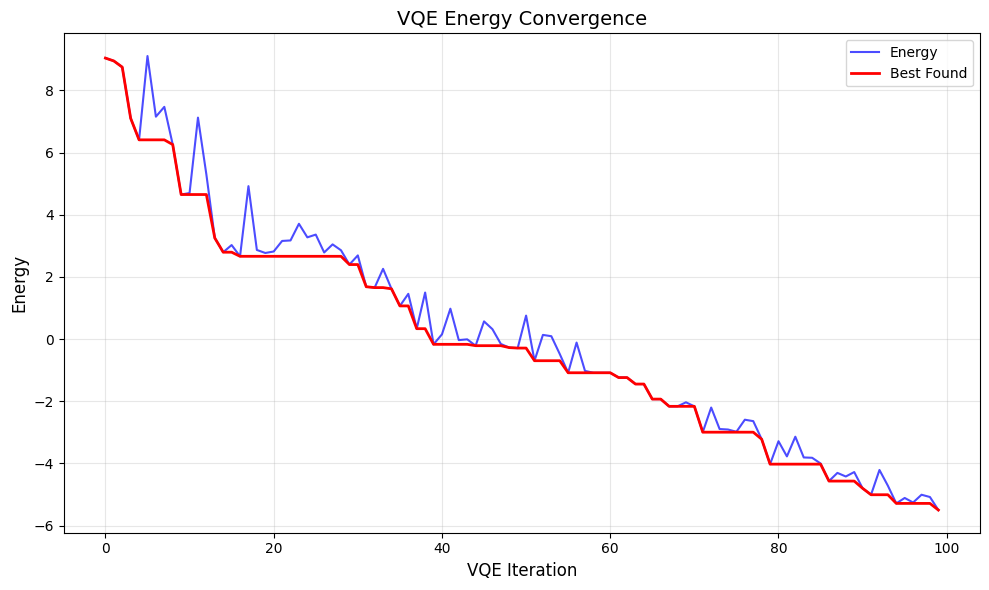

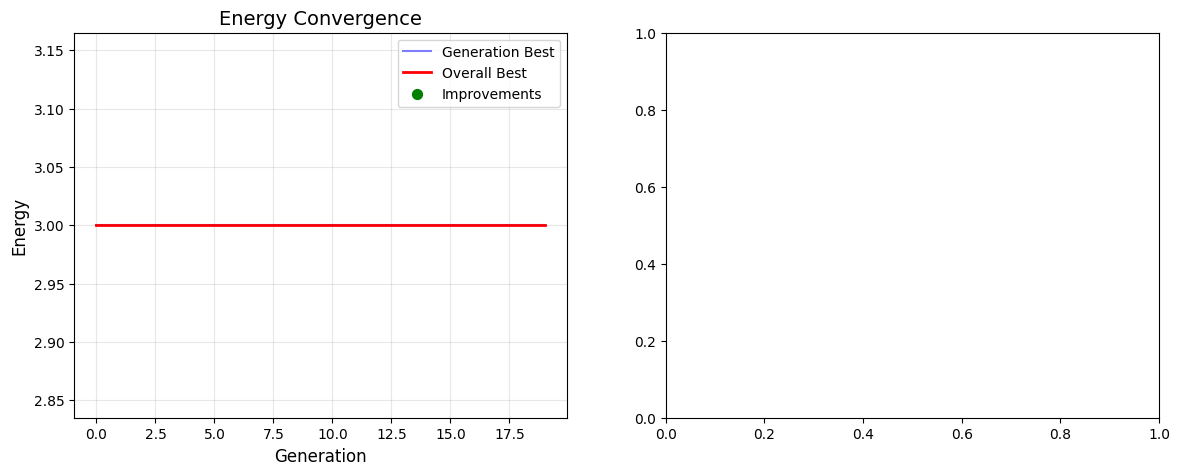

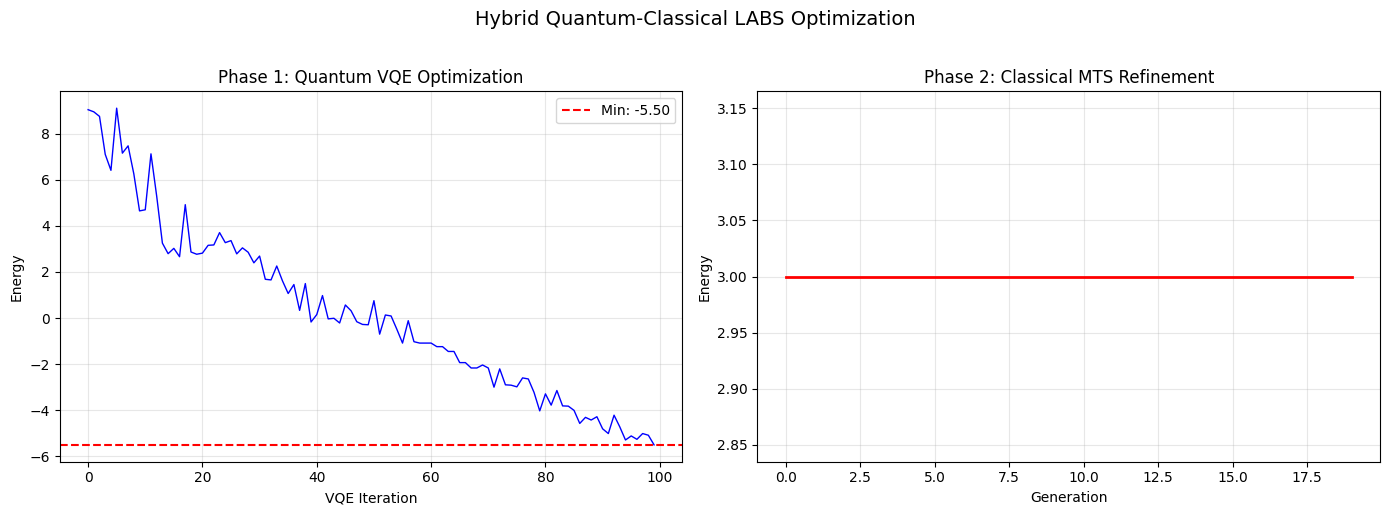

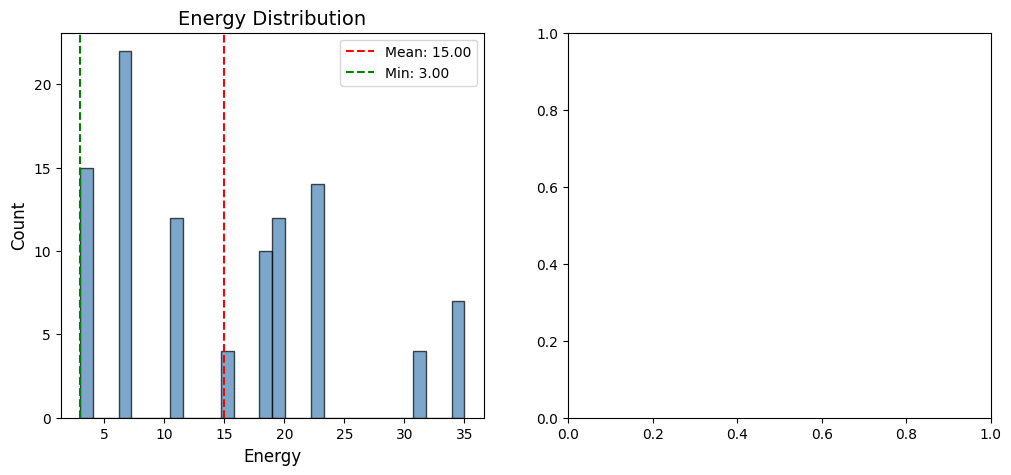

(<Figure size 1000x600 with 1 Axes>,
 <Figure size 1400x500 with 2 Axes>,
 <Figure size 1400x500 with 2 Axes>,
 <Figure size 1200x500 with 2 Axes>)

In [117]:
# Run your existing code first
n_qubits = 7
n_layers = 5
n_pop = 100

history, quantum_population = generate_quantum_pop(n_qubits, n_layers, n_pop)

config = MTSConfig(
    population_size=n_pop,
    max_generations=50,
    local_search_iterations=75,
    tabu_tenure=6
)

best_seq, best_energy, best_mf, stats = run_complete_hybrid_workflow(
    quantum_population=quantum_population,
    n_qubits=n_qubits,
    mts_config=config,
    verbose=True
)

# Generate visualizations
visualize_results(history, stats, quantum_population)


In [118]:
# Run scaling analysis across qubit counts
scaling_results = run_scaling_analysis(
    qubit_range=[7, 9, 11, 13],
    n_layers=5,
    n_pop=100,
    max_iter=100
)
# plt.savefig('scaling_analysis.png', dpi=150, bbox_inches='tight')
# plt.show()


Running n_qubits = 7

[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...
    Final energy: -5.500438

[4] Sampling population for classical seeding...
7 (100, 7)

[5] Population generated, Size: (100, 7)

Running n_qubits = 9

[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...
    Final energy: -2.475699

[4] Sampling population for classical seeding...
9 (100, 9)

[5] Population generated, Size: (100, 9)

Running n_qubits = 11

[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...
    Final energy: -2.915229

[4] Sampling population for classical seeding...
11 (100, 11)

[5] Population generated, Size: (100, 11)

Running n_qubits = 13

[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...


/home/jovyan/.qbraid/environments/n83d/pyenv/lib/python3.11/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 132
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


    Final energy: -3.536039

[4] Sampling population for classical seeding...
13 (100, 13)

[5] Population generated, Size: (100, 13)


TypeError: plot_scaling_analysis() missing 1 required positional argument: 'n_qubits'

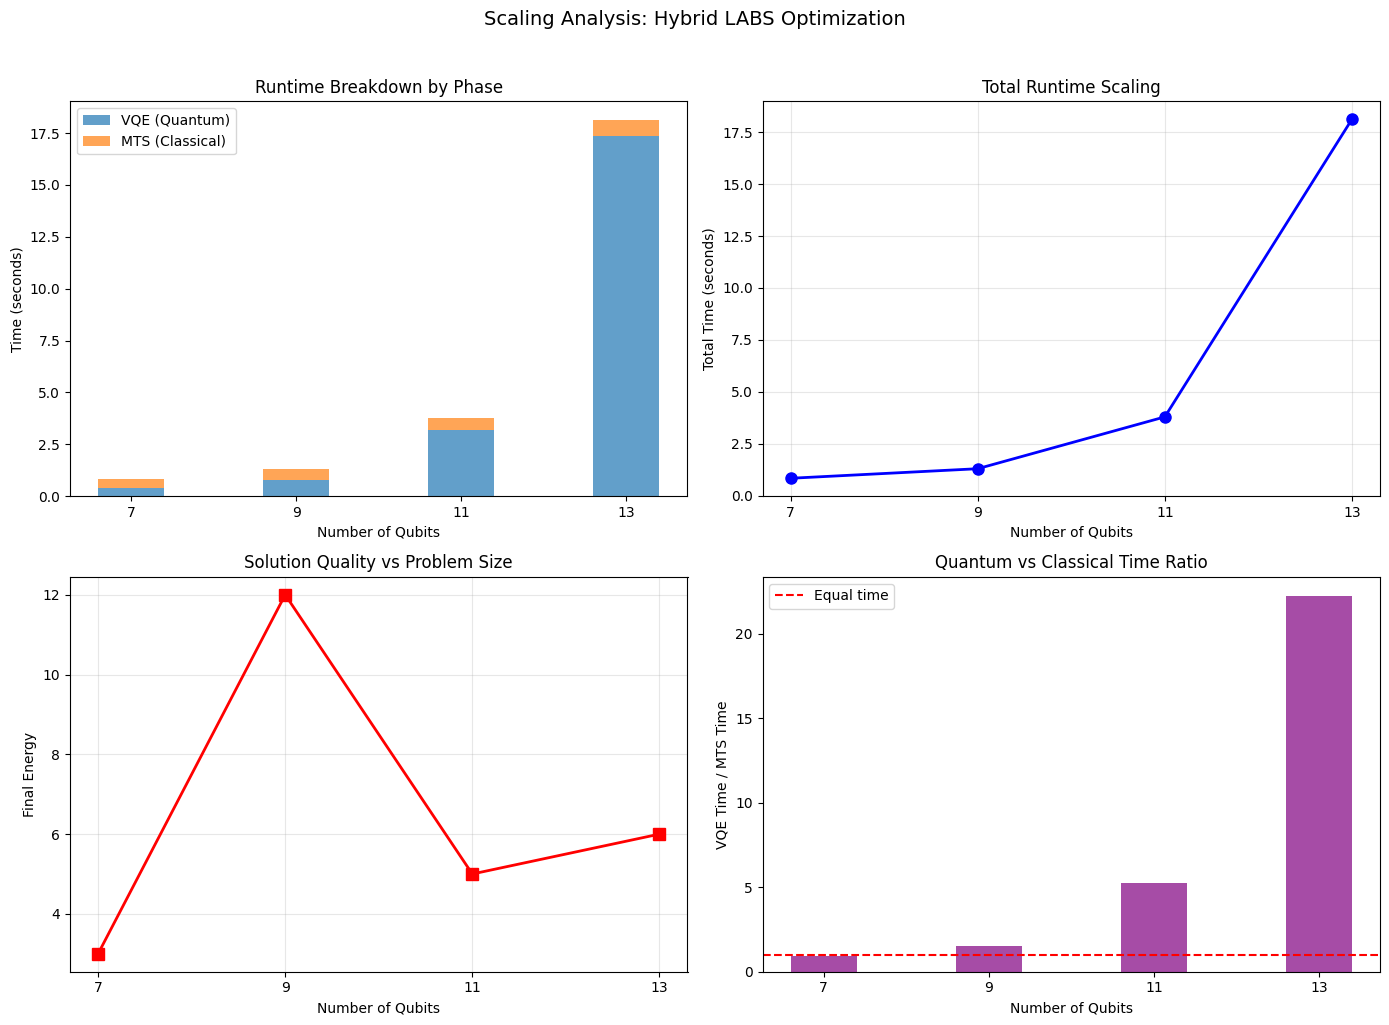

In [120]:
fig_scaling = plot_scaling_analysis(scaling_results, [7, 9, 11, 13])



In [47]:
n_qubits = 7
n_layers = 5
n_pop = 100

history, quantum_population = generate_quantum_pop(n_qubits, n_layers, n_pop)
print(np.shape(quantum_population))

# Run hybrid workflow
config = MTSConfig(
    population_size=n_pop,
    max_generations=50,
    local_search_iterations=75,
    tabu_tenure=6
)

best_seq, best_energy, best_mf, stats = run_complete_hybrid_workflow(
    quantum_population= quantum_population,
    n_qubits=n_qubits,
    mts_config=config,
    verbose=True
)

print(f"\n{'='*70}")
print("FINAL RESULT")
print(f"{'='*70}")
print(f"Best sequence: {best_seq.tolist()}")
print(f"Energy: {best_energy:.2f}")



[1] Building LABS Hamiltonian...

[2] Initializing variational parameters...

[3] Running VQE optimization...
    Final energy: -8.290679

[4] Sampling population for classical seeding...

[5] Population generated, Size: (100, 7)
(200,)
(100, 7)

QUANTUM-CLASSICAL HYBRID WORKFLOW

Quantum input: 100 sequences of length 7
Sequence length: 7
Population size: 100
Max generations: 50
Quantum seeds: 100

Initial best: E=3.00

[Generation Progress]
  Gen   0: Best E=3.00
  Gen 4: Applying intensification...
  Gen 9: Applying diversification...
  Gen  10: Best E=3.00

  Stopping: No improvement for 20 generations

----------------------------------------------------------------------
Final Results:
  Best sequence: [1, 1, 1, -1, -1, 1, -1]
  Best energy: 3.00
  Total evaluations: 2410

Workflow Statistics:
  Total evaluations: 2410
  Generations: 20
  Time: 0.42 seconds

FINAL RESULT
Best sequence: [1, 1, 1, -1, -1, 1, -1]
Energy: 3.00
